In [248]:
class AirData:  
  def __init__(self, data_path, skip_rows):
    self.data_path=data_path
    self.data=self.load_data(data_path, skip_rows)
    self.x=0
    self.y=0
    self.sc=0
  def copy_data(self): # Copy the AirData class to prevent bugs
    import copy
    return copy.deepcopy(self)

  def load_data(self, data_path, skip_rows): # Load the Air data with data_path parameter and skip_rows
    import pandas as pd
    import re
    station1 = pd.read_csv(data_path,sep=';',skiprows=skip_rows)# loading the data
    station1.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)# Renaming the columns
    station1.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
    station1.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
    station1.rename(columns = lambda x: re.sub('PM2.5.*','PM2.5',x), inplace = True)
    station1['Start'] = pd.to_datetime(station1['Start'])# Changing the time of the start and stop column into dateTime
    station1['Slut'] = pd.to_datetime(station1['Slut'])
    return station1

  def drop_columns(self, columns_to_drop): # Remove the "columns_to_drop" columns
    self.data=self.data.drop(columns=['Start', 'Slut'])
    self.data=self.data.drop(columns=columns_to_drop)# Dropping columns

  def scale_data(self): # Scale the data within range of 0 to 1.
    from sklearn.preprocessing import MinMaxScaler
    self.sc = MinMaxScaler(feature_range = (0, 1))
    self.data=self.sc.fit_transform(self.data.values.reshape(-1, 1))
    #print(self.sc.data_min_)
    #print(self.sc.data_max_)

  def delete_nan(self): # Delete the na values that raise error when running model
    import numpy as np
    #-------------------------------------#
    #Deleting the samples that contain nan
    index=[]
    for i in range(0,len(self.x)):
        if np.isnan(self.x[i]).any() or np.isnan(self.y[i]):
            index.append(i)
    X_new=np.delete(self.x,index, axis=0)
    y_new=np.delete(self.y,index)
    self.x=X_new
    self.y=y_new
  
  def create_windows(self): # Create the sub-sequences length of 5 from the actual data 
    import numpy as np
    # Setting up our training set and reshaping it to fit into the model
    X = []
    y= []
    for i in range(5, len(self.data)):
        X.append(self.data[i-5:i])
        y.append(self.data[i])
        
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

  def preprocessing(self, columns_to_drop, windowed=True): # Drop columns, apply scaling, 
                                                           # create windows (unless windowed parameter is set as False) and delete na values.
    self.drop_columns(columns_to_drop)
    self.scale_data()
    if windowed:
      self.x, self.y = self.create_windows()
    self.delete_nan()

In [264]:
train=AirData('/content/drive/My Drive/UPPSALA/ERICSSON PROJECT/Data/Train/shair-13349-1-6-3.csv',11)

In [265]:
train.preprocessing(columns_to_drop=['NOX', 'NO2'])

In [266]:
test=AirData('/content/drive/My Drive/UPPSALA/ERICSSON PROJECT/Data/Test/shair-18644-1-6-3.csv', 12)

In [267]:
test.data = test.data[test.data['Start']> "2019-12-01 00:00:00"]

In [268]:
test.preprocessing(columns_to_drop=['NOX', 'NO2', 'PM2.5'])

In [330]:
class Model:
  def __init__(self, reg_type, params, train, test, valid=0, rmse=0 ):
    self.params=params
    self.train=train
    self.test=test
    self.valid=valid
    self.rmse=rmse
    if reg_type=="lr":
      self.model_type="lr"
      self.model =self.create_lr_model()
    elif reg_type=="dnn":
      self.model_type="dnn"
      self.model = self.create_dnn_model()
    elif reg_type=="lstm":
      self.model_type="lstm"
      self.model = self.create_lstm_model()
    
  def create_lr_model(self): # Create linear regression model
    from sklearn.linear_model import LinearRegression
    X_train_nev= self.train.x.reshape(self.train.x.shape[0],-1)
    y_train_nev= self.train.y.reshape(self.train.y.shape[0],-1)
    reg = LinearRegression().fit(X_train_nev, y_train_nev)
    reg.score(X_train_nev, y_train_nev)
    reg.coef_
    reg.intercept_
    self.train.x = X_train_nev
    self.train.y = y_train_nev
    self.test.x = self.test.x.reshape(self.test.x.shape[0],-1)
    self.test.y = self.test.y.reshape(self.test.y.shape[0],-1)
    return reg
  
  def create_dnn_model(self):
    ##Things for new version
    return 0

  def create_lstm_model(self): # Create lstm model having dropout(0.2) layer after each LSTM layer to prevent overfitting
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Dropout
    regressor = Sequential()
    
    for i in range(len(self.params["network"])):
      if i==0:
        lstm_layer=LSTM(units = self.params["network"][i], return_sequences = True, input_shape = (self.train.x.shape[1], self.train.x.shape[2]))
      elif i==len(self.params["network"])-1:
        lstm_layer=LSTM(units = self.params["network"][i], return_sequences = self.params["seq_2_seq"])  
      else: 
        lstm_layer=LSTM(units = self.params["network"][i], return_sequences = True)
      
      regressor.add(lstm_layer)
      regressor.add(Dropout(0.2))
    
    regressor.add(Dense(units = 1))
    print(regressor.summary())
    regressor.compile(optimizer = self.params["optimizer"], loss = self.params["loss_func"])
    regressor.fit(self.train.x, self.train.y, epochs = self.params["epoch"], batch_size = self.params["batch_size"])
    return regressor

  def predict_descale(self): # prediction based on the windows of test data 
    predicted_lstm = self.model.predict(self.test.x)
    inv_predicted_lstm=self.test.sc.inverse_transform(predicted_lstm)
    inv_y_test_new=self.test.sc.inverse_transform(self.test.y.reshape(-1,1))
    return inv_y_test_new, inv_predicted_lstm
  
  def predict_next_n_hours(self, nof_days): # prediction based on point by point, can predict the next n hours, no use of test data
    import numpy as np
    predicted=np.array([])
    current=self.train.x[-1]
    for i in range(nof_days*24):
      if self.model_type == "lstm":
        predicted_one = self.model.predict(current.reshape(1,current.shape[0],1))
      elif self.model_type=="lr":
        predicted_one = self.model.predict(current.reshape(1,-1))

      inv_predicted_one=self.test.sc.inverse_transform(predicted_one)
      predicted=np.append(predicted, inv_predicted_one)
      current=current[1:]
      current=np.append(current, predicted_one)

    inv_y_test_new=self.test.sc.inverse_transform(self.test.y.reshape(-1,1))
    return inv_y_test_new[:nof_days*24], predicted

  def evaluate(self, predicted): # Return root-mean-square-error of the model as loss function
    from sklearn.metrics import mean_squared_error
    import math
    self.rmse = math.sqrt(mean_squared_error(predicted[0], predicted[1]))
    print(self.rmse)
  
  def visualise(self, predicted): # Plot predicted vs. actual data from test data
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,6))
    plt.plot(predicted[0], color = 'black', label = 'PM10')
    plt.plot(predicted[1], color = 'green', label = 'Predicted PM10')
    plt.title('PM10 Predictions')
    plt.xlabel('Time')
    plt.ylabel('PM10')
    plt.legend()
    plt.show()

  def plot_loss(self): # Plot training and test loss graph vs. epoch number
    ##Things for new version
    return 0

In [336]:
params={"network": [50,50,50,50],"batch_size":32, "epoch":15, "optimizer":'adam', "loss_func":'mean_squared_error', "seq_2_seq":False}

1. LSTM MODEL

In [337]:
lstm= Model("lstm", params, train.copy_data(), test.copy_data())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 5, 50)             10400     
_________________________________________________________________
dropout_60 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_61 (LSTM)               (None, 5, 50)             20200     
_________________________________________________________________
dropout_61 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 5, 50)             20200     
_________________________________________________________________
dropout_62 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 50)              

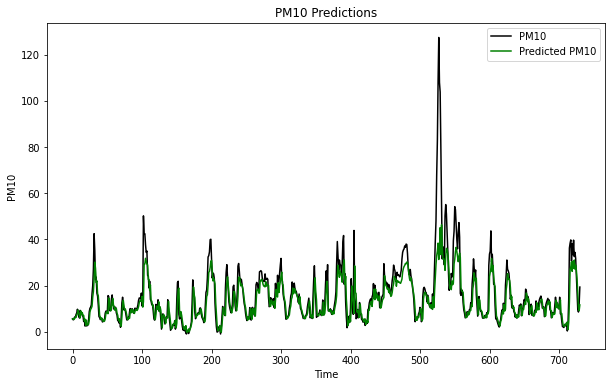

In [338]:
lstm.visualise(lstm.predict_descale())

In [339]:
lstm.evaluate(lstm.predict_descale())

8.183182728237272


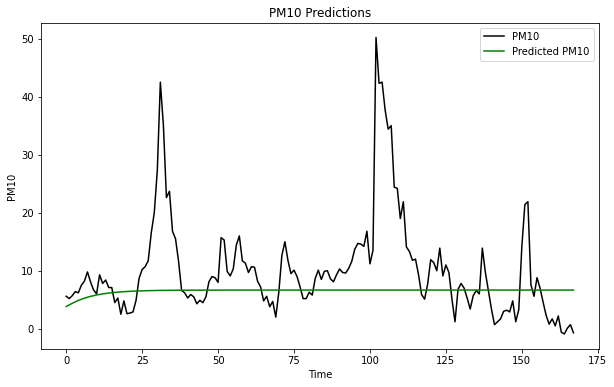

In [340]:
lstm.visualise(lstm.predict_next_n_hours(nof_days= 7)) #predict the next 7 days each having 24 hours thus 7*24 hours

In [341]:
lstm.evaluate(lstm.predict_next_n_hours(nof_days= 7)) 

9.268757801812146


2. LR MODEL

In [331]:
lr= Model("lr", params, train.copy_data(), test.copy_data())

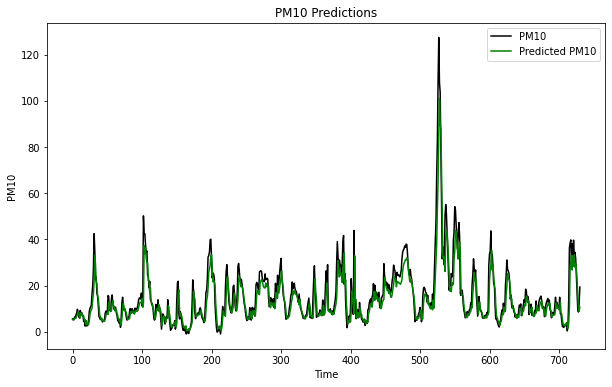

In [332]:
lr.visualise(lr.predict_descale())

In [333]:
lr.evaluate(lr.predict_descale())

5.992588307719218


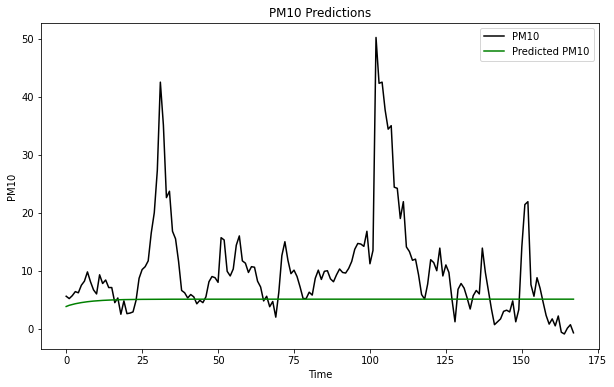

In [334]:
lr.visualise(lr.predict_next_n_hours(nof_days = 7))

In [335]:
lr.evaluate(lr.predict_next_n_hours(nof_days = 7))

9.95955300898664


3. DNN MODEL